In [1]:
from LOTlib3.Grammar import Grammar
from math import log
from LOTlib3.Hypotheses.LOTHypothesis import LOTHypothesis
from LOTlib3.DataAndObjects import FunctionData
from LOTlib3.TopN import TopN
from LOTlib3.Samplers.MetropolisHastings import MetropolisHastingsSampler
from LOTlib3.Eval import primitive

In [35]:
import numpy as np
import pandas as pd

import os
import json
import time
import copy

from IPython.display import clear_output
from IPython.display import HTML

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors

from PIL import Image, ImageDraw
from IPython.display import Image as Im
from itertools import permutations, combinations
from sympy.utilities.iterables import multiset_permutations

# from skimage.segmentation import flood, flood_fill

%matplotlib inline

In [19]:
# define solver
class ARCSolver:
    def __init__(self, task_filename):
        # load task and extract input and output pairs
        self.task_filename = task_filename
        self.task = self.load_task(task_filename)
        self.train_inputs, self.train_outputs, self.test_inputs, self.test_outputs = \
            self.extract_io_pairs()
        self.test_pred = np.zeros((5, 5))
        self.test_pred_height, self.test_pred_width = self.test_pred.shape
        
        self.solved = False  # have we solved the task yet?
        self.selected_colour = 0
        self.clipboard = None
        self.description = ''
        
        # variables for plotting
        self.cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        self.colour_to_num = {'black': 0, 'blue': 1, 'red': 2, 'green': 3, 'yellow': 4,
                             'grey': 5, 'magenta': 6, 'orange': 7, 'light_blue': 8, 
                             'maroon': 9}
        self.num_to_colour = {0: 'black', 1: 'blue', 2: 'red', 3: 'green', 4: 'yellow',
                             5: 'grey', 6: 'magneta', 7: 'orange', 8: 'light_blue',
                             9: 'maroon'}

        
    def load_task(self, task_filename):
        with open(task_filename, 'r') as f:
            task = json.load(f)    
        return task

    def plot_task(self):
        """
        Plots the first train and test pairs of a specified task,
        using same color scheme as the ARC app
        """
        norm = colors.Normalize(vmin=0, vmax=9)
        n_train = len(self.task['train'])
        fig, axs = plt.subplots(n_train+1, 2, figsize=(10, 10))
        for i in range(n_train):
            axs[i, 0].imshow(self.task['train'][i]['input'], cmap=self.cmap, norm=norm)
            axs[i, 0].axis('off')
            axs[i, 0].set_title('Train Input')
            axs[i, 1].imshow(self.task['train'][i]['output'], cmap=self.cmap, norm=norm)
            axs[i, 1].axis('off')
            axs[i, 1].set_title('Train Output')
        axs[n_train, 0].imshow(self.task['test'][0]['input'], cmap=self.cmap, norm=norm)
        axs[n_train, 0].axis('off')
        axs[n_train, 0].set_title('Test Input')
        axs[n_train, 1].imshow(self.task['test'][0]['output'], cmap=self.cmap, norm=norm)
        axs[n_train, 1].axis('off')
        axs[n_train, 1].set_title('Test Output')
        plt.tight_layout()
        plt.show()
    
    def plot_grid(self, grid):
        """
        Plots a single grid
        """
        #plt.clf()

        #plt.draw()
        #display(plt)
        

    def plot_grids(self, grids):
        """
        Plots a list of grids
        """
        n_grids = len(grids)
        norm = colors.Normalize(vmin=0, vmax=9)
        fig, axs = plt.subplots(1, n_grids, figsize=(6, 6), squeeze=False)
        for i in range(n_grids):
            axs[0, i].imshow(grids[i], cmap=self.cmap, norm=norm)
            axs[0, i].axis('off')
        plt.tight_layout()
        plt.show()
    
    def extract_io_pairs(self):
        train = self.task['train']
        test = self.task['test']
        n_train = len(train)
        n_test = len(test)

        train_inputs = np.array([train[i]['input'] for i in range(n_train)])
        train_outputs = np.array([train[i]['output'] for i in range(n_train)])
        test_inputs = np.array([test[i]['input'] for i in range(n_test)])
        test_outputs = np.array([test[i]['output'] for i in range(n_test)])

        return train_inputs, train_outputs, test_inputs, test_outputs
    
    def copy_from_input(self):
        # copy over the first test input
        self.test_pred = self.test_inputs[0].copy()
        self.test_pred_height, self.test_pred_width = self.test_inputs[0].shape
        self.description = 'copy from input'
    
    def reset(self):
        # resets grid to all zeros with size of the grid based on current settings
        self.test_pred = np.zeros((self.test_pred_height, self.test_pred_width))
        self.description = 'reset'
    
    def resize(self):
        # resizes the grid
        prev_test_pred = self.test_pred.copy()
        prev_test_pred_width = self.test_pred_width
        prev_test_pred_height = self.test_pred_height

        # sample new grid size
        new_test_pred_width = np.random.choice(np.arange(1, 5))
        new_test_pred_height = np.random.choice(np.arange(1, 5))
        new_test_pred = np.zeros((new_test_pred_height, new_test_pred_width))
        
        # copy over values
        for i in range(min(prev_test_pred_height, new_test_pred_height)):
            for j in range(min(prev_test_pred_width, new_test_pred_width)):
                new_test_pred[i, j] = prev_test_pred[i, j]
            
        self.test_pred = new_test_pred
        self.test_pred_width = new_test_pred_width
        self.test_pred_height = new_test_pred_height
        self.description = f'resize: ({new_test_pred_height}, {new_test_pred_width})'
        
    def change_colour(self):
        self.selected_colour = np.random.choice(np.arange(10))
        self.description = f'change colour: {self.num_to_colour[self.selected_colour]}'
    
    def edit(self):
        # select a random location
        x = np.random.choice(np.arange(self.test_pred_width))
        y = np.random.choice(np.arange(self.test_pred_height))
        self.test_pred[y, x] = self.selected_colour
        self.description = f'edit: ({y}, {x})'
    
    def edit_rectangle(self):
        # selects a randomly selected region and changes the colour of all of the cells
        x_start = np.random.choice(np.arange(self.test_pred_width))
        x_end = np.random.choice(np.arange(x_start+1, self.test_pred_width+1))
        y_start = np.random.choice(np.arange(self.test_pred_height))
        y_end = np.random.choice(np.arange(y_start+1, self.test_pred_height+1))
        
        # select a new colour
        self.selected_colour = np.random.choice(np.arange(10))
        self.test_pred[y_start:y_end, x_start:x_end] = self.selected_colour
        self.description = f'edit rectangle from ({y_start}:{y_end}, {x_start}:{x_end}) to {self.selected_colour}'
    
    def copy(self):
        # copies a randomly selected region
        x_start = np.random.choice(np.arange(self.test_pred_width))
        x_end = np.random.choice(np.arange(x_start+1, self.test_pred_width+1))
        y_start = np.random.choice(np.arange(self.test_pred_height))
        y_end = np.random.choice(np.arange(y_start+1, self.test_pred_height+1))
        
        self.clipboard = self.test_pred[y_start:y_end, x_start:x_end].copy()
        self.description = f'copy from ({y_start}:{y_end}, {x_start}:{x_end})'
        #print(f'clipboard: {self.clipboard}')
    
    def paste(self):
        # pastes clipboard value into randomly selected location
        clipboard_height, clipboard_width = self.clipboard.shape
        x_start = np.random.choice(np.arange(self.test_pred_width))
        x_width = min(clipboard_width, self.test_pred_width - x_start) 
        y_start = np.random.choice(np.arange(self.test_pred_height))
        y_height = min(clipboard_height, self.test_pred_height - y_start)
        
        self.test_pred[y_start:y_start+y_height, x_start:x_start+x_width] = self.clipboard[:y_height, :x_width] 
        self.description = f'pasting from ({y_start}:{y_start+y_height}, {x_start}:{x_start+x_width})'
    
    def flood_fill(self):
        # flood fill at a random location
        x = np.random.choice(self.test_pred_width)
        y = np.random.choice(self.test_pred_height)
        self.test_pred = flood_fill(self.test_pred, (y, x), 
                                    self.selected_colour)
        self.description = f'flood fill from: ({y}, {x})'
     
    def solve(self):
        fig = plt.figure(figsize=(6, 6))
        plt.ion()
        plt.show()
        norm = colors.Normalize(vmin=0, vmax=9)
                
        while not self.solved:
            clear_output()
            # randomly select available function
            if np.random.choice([0, 1]) == 0:
                self.change_colour()
            else:
                self.edit()

            plt.imshow(self.test_pred, cmap=self.cmap, norm=norm)
            plt.axis('off')
            plt.tight_layout()
            plt.pause(1)
                        
            # check accuracy
            
            

In [21]:
# displaying a single grid
def DisplayGrid(grid):
    grid = np.asarray(grid)
    nrows = len(grid[:,0])
    ncols = len(grid[0,:])
    height, width = nrows*50, ncols*50
    image = Image.new(size=(width,height),mode='RGB',color=(255,255,255))
    draw = ImageDraw.Draw(image)
    r = 0 
    for row in grid:
        c = 0
        for col in row:
            draw.rectangle(xy=[c*50,r*50,(c+1)*50,(r+1)*50], fill=colorMap[np.abs(grid[r][c])])
            c += 1
        r += 1
    for i in range(ncols):
        draw.line([(i+1)*50,0,(i+1)*50,height],fill="grey")
    for i in range(nrows):
        draw.line([0,(i+1)*50,width,(i+1)*50],fill="grey")
    display(image)

In [22]:
colorMap = {0:"black",1:"blue",2:"red", 3:"green",4:"yellow",5:"grey",6:"magenta",7:"orange",8:"cyan",9:"brown"}

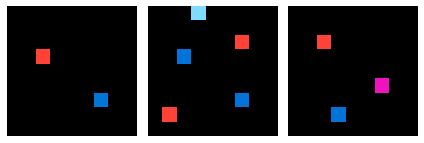

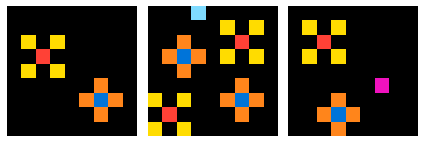

In [31]:
training_path = "/Users/aysjajohnson/Desktop/ARC-master/data/training/"
solver = ARCSolver(task_filename=os.path.join(training_path, '0ca9ddb6.json'))
solver.plot_grids(solver.train_inputs)
solver.plot_grids(solver.train_outputs)

In [5]:
b = 0.05

How do you get LOTlib to start with a hypothesis and expand from there? This is awkward right now -- you have to add the input as a rule...

It also doesn't really understand how to compile lists of lists, just numbers.. I think we'd need to change the backend a bit

In [107]:
# intializing basic hypothesis, will edit later
class ARCHypothesis(LOTHypothesis):
    def __init__(self, **kwargs):
        LOTHypothesis.__init__(self, grammar=grammar, display="lambda grid: %s", **kwargs)
        
    def __call__(self, *args):
        try:
            # try to do it from the superclass
            return LOTHypothesis.__call__(self, *args)
        except ZeroDivisionError:
            # and if we get an error, return nan
            return float("nan")

    def compute_single_likelihood(self, datum):
        # for each correct pixel, add log(1), for each incorrect, add log(exp(-b))
        ll = 0
        input_grid = self(*datum.input)
        output_grid = datum.output
        # assuming input and output are the same size for now
        height, width = len(input_grid[:,0]), len(input_grid[0,:])
        for i in range(height):
            for j in range(width):
                if input_grid[i][j] == output_grid[i][j]:
                    ll += log(1)
                elif input_grid[i][j] == 0 and output_grid[i][j] != 0:
                    ll += log(0.1)
                else:
                    ll += log(0.05)
        # print(self.value, ll)
        return ll
        
    def display_hypothesis(self):
        return self.value

In [33]:
inputs = solver.train_inputs
outputs = solver.train_outputs
print([inputs[0]])

[array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])]


In [34]:
data = [FunctionData(input=[inputs[0]],output=outputs[0])]
print(data)

[<[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]] -> [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 4 0 4 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 4 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 7 1 7 0]
 [0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 0]]>]


In [36]:
@primitive
def red_squares_(grid):
    grid = copy.deepcopy(grid)
    height, width = len(grid[:,0]), len(grid[0,:])
    lst = []
    for i in range(height):
        for j in range(width):
            if grid[i][j] == 2:
                lst.append((i,j))
    return lst

@primitive
def blue_squares_(grid):
    grid = copy.deepcopy(grid)
    height, width = len(grid[:,0]), len(grid[0,:])
    lst = []
    for i in range(height):
        for j in range(width):
            if grid[i][j] == 1:
                lst.append((i,j))
    return lst

@primitive
def diag_(lst, grid):
    grid = copy.deepcopy(grid)
    height, width = len(grid[:,0]), len(grid[0,:])
    diag_lst = []
    for tup in lst:
        # check whether diagonals exist on board constraints
        N, E, S, W = tup[0]-1, tup[1] + 1, tup[0] + 1, tup[1] -1
        if  N > 0 and S < height-1 and W > 0 and E < width - 1:
            diag_lst.extend([(N,W),(N,E),(S,E),(S,W)])
    return diag_lst

@primitive
def cross_(lst, grid):
    grid = copy.deepcopy(grid)
    height, width = len(grid[:,0]), len(grid[0,:])
    cross_lst = []
    for tup in lst:
        # check whether diagonals exist on board constraints
        N, E, S, W = tup[0]-1, tup[1] + 1, tup[0] + 1, tup[1] -1
        if  N > 0 and S < height-1 and W > 0 and E < width - 1:
            cross_lst.extend([(N,tup[1]),(tup[0],E),(S,tup[1]),(tup[0],W)])
    return cross_lst

@primitive
def color_(lst, clr):
    return {k:clr for k in lst}

@primitive
def paint_(dict_, grid):
    grid = copy.deepcopy(grid)
    height, width = len(grid[:,0]), len(grid[0,:])
    for coord in dict_.keys():
        grid[coord[0]][coord[1]] = dict_[coord]
    return grid

In [108]:
# initializing grammar
grammar = Grammar(start='GRID')

# adding production rules
grammar.add_rule('LIST', 'red_squares_', ['GRID'], 1.0)
grammar.add_rule('LIST', 'blue_squares_', ['GRID'], 1.0)
grammar.add_rule('LIST', 'diag_', ['LIST', 'GRID'], 1.0)
grammar.add_rule('LIST', 'cross_', ['LIST', 'GRID'], 1.0)
grammar.add_rule('DICT', 'color_', ['LIST','COLOR'], 1.0)
grammar.add_rule('GRID', 'paint_', ['DICT', 'GRID'], 1.0)

# adding numbers 0 through 9 as terminals
# for n in range(10):
#     grammar.add_rule('COLOR', str(n), None, 1.0)

# right now just consider 4 and 7 to see if this makes the right solution come up
grammar.add_rule('COLOR', str(4), None, 1.0)
grammar.add_rule('COLOR', str(7), None, 1.0)

grammar.add_rule('GRID', 'grid', None, 3.0)

GRID -> grid	w/ p=3.0

In [38]:
rs = red_squares_(inputs[0])

In [86]:
diag_(rs, inputs[0])

[(2, 1), (2, 3), (4, 3), (4, 1)]

In [87]:
grammar.display_rules()

LIST -> red_squares_['GRID']	w/ p=1.0
LIST -> blue_squares_['GRID']	w/ p=1.0
LIST -> diag_['LIST', 'GRID']	w/ p=1.0
LIST -> cross_['LIST', 'GRID']	w/ p=1.0
DICT -> color_['LIST', 'COLOR']	w/ p=1.0
GRID -> paint_['DICT', 'GRID']	w/ p=1.0
GRID -> grid	w/ p=3.0
COLOR -> 0	w/ p=1.0
COLOR -> 1	w/ p=1.0
COLOR -> 2	w/ p=1.0
COLOR -> 3	w/ p=1.0
COLOR -> 4	w/ p=1.0
COLOR -> 5	w/ p=1.0
COLOR -> 6	w/ p=1.0
COLOR -> 7	w/ p=1.0
COLOR -> 8	w/ p=1.0
COLOR -> 9	w/ p=1.0


In [92]:
h = ARCHypothesis()
print(h)

lambda grid: paint_(color_(blue_squares_(grid), 7), paint_(color_(red_squares_(grid), 4), grid))


In [93]:
h(inputs[0])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 7, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

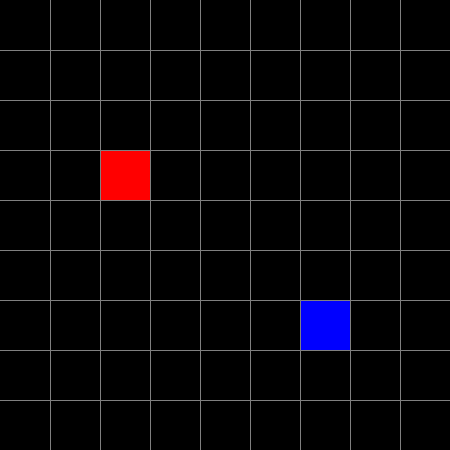

In [88]:
DisplayGrid(h(inputs[0]))

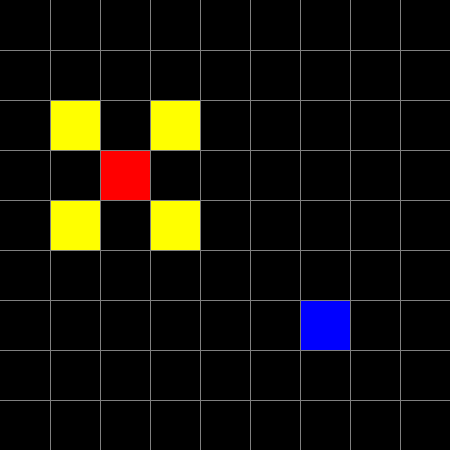

In [90]:
DisplayGrid(paint_(color_(diag_(red_squares_(inputs[0]),inputs[0]),4),inputs[0]))

In [110]:
# problem: MHS considers the class to have no arguments. Current workaround, globally declare num_vars before running

tn = TopN(N=10) # store the top N

h0 = ARCHypothesis()
print(h0)

for h in MetropolisHastingsSampler(h0, data, steps=1000):
    tn.add(h)

for h in tn.get_all(sorted=True):
    print(h.posterior_score, h.likelihood,  h.prior, h)

lambda grid: grid
*** Runtime error in paint_(DICT, GRID)
*** Runtime error in blue_squares_(GRID)
*** Runtime error in diag_(LIST, GRID)
*** Runtime error in cross_(LIST, GRID)
*** Runtime error in diag_(LIST, GRID)
*** Runtime error in diag_(LIST, GRID)
*** Runtime error in color_(LIST, COLOR)
*** Runtime error in paint_(DICT, GRID)
*** Runtime error in paint_(DICT, GRID)
*** Runtime error in blue_squares_(GRID)
*** Runtime error in diag_(LIST, GRID)
*** Runtime error in cross_(LIST, GRID)
*** Runtime error in cross_(LIST, GRID)
*** Runtime error in color_(LIST, COLOR)
*** Runtime error in paint_(DICT, GRID)
*** Runtime error in diag_(LIST, GRID)
*** Runtime error in color_(LIST, COLOR)
*** Runtime error in paint_(DICT, GRID)
*** Runtime error in diag_(LIST, GRID)
*** Runtime error in color_(LIST, COLOR)
*** Runtime error in paint_(DICT, GRID)
*** Runtime error in blue_squares_(GRID)
*** Runtime error in diag_(LIST, GRID)
*** Runtime error in color_(LIST, COLOR)
*** Runtime error in 

RecursionError: maximum recursion depth exceeded while calling a Python object

In [47]:
print(h)

lambda grid: grid


In [48]:
print(inputs[0])

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
